In [5]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['legend.fontsize']=11

fig_width = 6
fig_width_big = 12

<>:65: SyntaxWarning: invalid escape sequence '\o'
<>:65: SyntaxWarning: invalid escape sequence '\o'
C:\Users\39340\AppData\Local\Temp\ipykernel_15696\235933066.py:65: SyntaxWarning: invalid escape sequence '\o'
  axes[0].set_ylabel("$\omega$ [rpm]")


['c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\OL_experiments_current_profile/final_fixed\\inertia05_ki-0.0029-kp-3.0000', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\OL_experiments_current_profile/final_fixed\\inertia07_ki-0.0029-kp-3.0000', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\OL_experiments_current_profile/final_fixed\\inertia09_ki-0.0029-kp-3.0000', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\OL_experiments_current_profile/final_fixed\\inertia11_ki-0.0029-kp-3.0000', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\OL_experiments_current_profile/final_fixed\\inertia13_ki-0.0029-kp-3.0000', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\OL_experiments_current_profile/final_fixed\\inertia15_ki-0.0029-kp-3.0000']
['inertia05', 'inertia07', 'inertia09', 'inertia11', 'inertia13', 'inertia15']
['c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\OL_experiments_current_profile/final

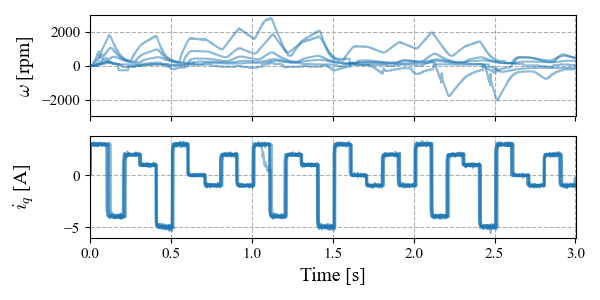

In [6]:
current_path = os.getcwd().split("in-context-bldc")[0]
data_path = os.path.join(current_path,"in-context-bldc", "data")

folder = "OL_experiments_current_profile/final_fixed"
folder_path = os.path.join(data_path, folder)

list_of_folders = glob.glob(os.path.join(folder_path, '*'))[:6]
print(list_of_folders)
identifiers = [list_of_folders[i].split("_")[-2][-9:] for i in range(len(list_of_folders))]
print(identifiers)

#### inertias [e-4]: I5 = 0.7, I13 = 1.4, I15 = 3.1, I9 = 5.8, I11 = 6.8, I7 = 8.8
order = [4, 0, 5, 2, 3, 1]
list_of_folders = [list_of_folders[j] for j in order]
identifiers = [identifiers[j] for j in order]
print(list_of_folders)
print(identifiers)

profile_list_real = []
current_list = []

for exp_idx in range(len(list_of_folders)):
    profile_config_real = []
    current_config = []
    exp_path = list_of_folders[exp_idx]
    csv_list = glob.glob(os.path.join(exp_path, "*.csv"))
    for file in csv_list:

        df = pd.read_csv(file)
        iq_tmp = df["iq"].to_numpy()
        start_idx = (np.argwhere(np.abs(iq_tmp)>1)[0] - 3)[0]
        last_idx = start_idx + 3003
        iq = iq_tmp[start_idx:last_idx]
        omega = df["omega"].to_numpy()[start_idx:last_idx]
        time = df['t'].to_numpy()[start_idx:last_idx]
        time = time - time[0]

        profile_config_real.append(omega)
        current_config.append(iq)

    profile_list_real.append(  np.row_stack(profile_config_real)    )
    current_list.append(  np.row_stack(current_config)    )
    # print(np.row_stack(profile_config_real).shape)

# print(rmse_list_meta)


profile_full_real = np.stack(profile_list_real)
current_full = np.stack(current_list)
config_number, exp_number, exp_length = profile_full_real.shape
print(config_number)
print(exp_number)
print(exp_length)


fig, axes = plt.subplots(2,1,figsize=(6,3), sharex=True)

for i in range(config_number):
    axes[0].plot(time, profile_full_real[i,0,:], c= "tab:blue", alpha = 0.5) #, label= "$S^{config}$".format(config = i))
    axes[1].plot(time, current_full[i,0,:], c= "tab:blue", alpha = 0.5) #, label= "$S^{config}$".format(config = i))
    

# axes[0].legend(ncols= 1, loc= "center left", bbox_to_anchor = [1.04,0.5])
# axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("$\omega$ [rpm]")
axes[0].set_ylim([-3000,3000])
# axes[1].legend(ncols= 1, loc= "center left", bbox_to_anchor = [1.04,0.5])
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("$i_q$ [A]")
plt.tight_layout()
fig.align_ylabels(axes)
# plt.savefig("figures\\OL_traj.pdf", dpi=300)

plt.show()

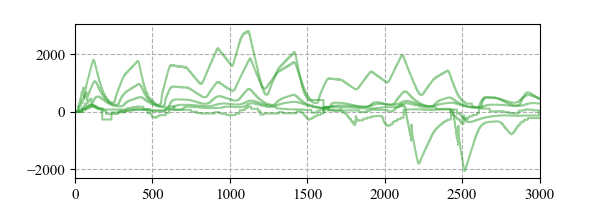

In [7]:
plt.figure(figsize=(6,2))
color_palette = ["#0b3319","#15751e","#39a325","#79e230","#c0ff35","#f9fba5"]

for i in range(len(list_of_folders)):
    plt.plot(profile_full_real[i,0,:], color = "tab:green", alpha = 0.5)

plt.show()